# Building a Multi-Agent Supervisor Workflow with LangGraph and Snowflake

This notebook demonstrates how to build a **multi-agent supervisor architecture** using LangGraph and Snowflake Cortex Agents. The workflow consists of:

- **Supervisor**: An AI coordinator that routes queries to specialized agents and synthesizes their responses
- **Content Agent**: Handles customer feedback, sentiment analysis, and communication intelligence
- **Data Analyst Agent**: Handles customer behavior, business metrics, and predictive analytics
- **Research Agent**: Handles market intelligence, strategic analysis, and competitive insights

## Architecture Overview

```
START → Supervisor (Route) → Specialized Agent → Supervisor (Synthesize) → END
```

The supervisor makes two passes:
1. **Routing Pass**: Analyzes the query and routes to the appropriate agent
2. **Synthesis Pass**: Combines agent output into an executive summary


## Step 1: Install and Import Dependencies

First, let's import all the necessary libraries. We'll need:
- **LangChain Core**: For message types and prompt templates
- **LangChain Snowflake**: For Snowflake-specific integrations (ChatSnowflake, SnowflakeCortexAgent)
- **LangGraph**: For building the stateful workflow graph


In [ ]:
# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph.message import MessagesState

# LangChain imports
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate

# Fix for langchain_snowflake import compatibility issue
# Tool class moved from langchain.tools to langchain_core.tools in newer LangChain
import langchain.tools
from langchain_core.tools import Tool
langchain.tools.Tool = Tool  # Shim for backwards compatibility

# Snowflake imports
from langchain_snowflake import ChatSnowflake, SnowflakeCortexAgent, create_session_from_env
from snowflake.snowpark import Session

# Utility imports
import json
import os
from typing import Dict, List, Optional, Literal
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("✅ All imports loaded successfully")


✅ All imports loaded successfully


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/langchain_snowflake/chat_models/base.py:26: UserWarning: Field name "schema" in "ChatSnowflake" shadows an attribute in parent "BaseChatModel"
  class ChatSnowflake(


## Step 2: Define the Workflow State

LangGraph uses a **state** object that flows through the graph. We'll use the built-in `MessagesState` which provides:
- A `messages` list that accumulates all messages in the conversation
- Automatic message deduplication and ordering

The state is shared across all nodes and gets updated as the workflow progresses.


In [2]:
# Extend MessagesState to include execution plan tracking
class State(MessagesState):
    """Extended state that tracks execution plan and progress.
    
    Designed for efficient single-pass execution:
    - Plan is created ONCE and never modified during execution
    - Agents chain directly to each other without supervisor re-entry
    - Errors are aggregated, not cascaded
    """
    plan: Optional[Dict] = None  # The supervisor's explicit plan (immutable after creation)
    current_step: int = 0  # Current step being executed in the plan
    agent_outputs: Dict = {}  # Accumulated outputs from all agents (avoids message parsing)
    execution_errors: List = []  # Aggregated errors (not per-chunk)
    planning_complete: bool = False  # Flag to skip re-planning
    
print("✅ State defined with efficiency optimizations")


✅ State defined with efficiency optimizations


## Step 3: Create Snowflake Session

We need to establish a connection to Snowflake. The `create_session_from_env()` function reads credentials from environment variables:
- `SNOWFLAKE_ACCOUNT`
- `SNOWFLAKE_USER`
- `SNOWFLAKE_PASSWORD`
- `SNOWFLAKE_DATABASE`
- `SNOWFLAKE_SCHEMA`
- `SNOWFLAKE_WAREHOUSE`

Make sure you have a `.env` file with these variables set.


In [3]:
# Create Snowflake session from environment variables
try:
    session = create_session_from_env()
    
    # Get database and schema, stripping any quotes that Snowflake might add
    current_database = session.get_current_database().strip('"')
    current_schema = session.get_current_schema().strip('"')
    
    # IMPORTANT: Ensure warehouse is set - required for Cortex Analyst tools
    warehouse = os.getenv('SNOWFLAKE_WAREHOUSE', 'COMPUTE_WH')
    session.sql(f"USE WAREHOUSE {warehouse}").collect()
    current_warehouse = session.get_current_warehouse()
    if current_warehouse:
        current_warehouse = current_warehouse.strip('"')
    
    print("✅ Snowflake session created successfully!")
    print(f"   Database: {current_database}")
    print(f"   Schema: {current_schema}")
    print(f"   Warehouse: {current_warehouse}")
    
except Exception as e:
    print(f"❌ Snowflake connection failed: {e}")
    print("   Please check your .env file and Snowflake credentials")
    raise


✅ Snowflake session created successfully!
   Database: CUSTOMER_INTELLIGENCE_DB
   Schema: PUBLIC
   Warehouse: COMPUTE_WH


## Step 4: Initialize the Supervisor Model

The **Supervisor** is the brain of our multi-agent system. It uses Snowflake's Cortex LLM service (`ChatSnowflake`) to:
1. Analyze incoming queries
2. Route them to the appropriate specialized agent
3. Synthesize the agent's response into an executive summary

We use `claude-4-sonnet` with low temperature (0.1) for consistent, deterministic routing decisions.


In [4]:
# Initialize the supervisor model using Snowflake Cortex
supervisor_model = ChatSnowflake(
    session=session,
    model="claude-4-sonnet",  # Claude 4 Sonnet via Snowflake Cortex
    temperature=0.1,          # Low temperature for consistent routing
    max_tokens=2000           # Limit response length
)

print("✅ Supervisor model initialized!")
print(f"   Model: claude-4-sonnet")
print(f"   Temperature: 0.1 (deterministic)")
print(f"   Max tokens: 2000")


✅ Supervisor model initialized!
   Model: claude-4-sonnet
   Temperature: 0.1 (deterministic)
   Max tokens: 2000


## Step 5: Initialize Specialized Cortex Agents

Now we initialize our three specialized **Snowflake Cortex Agents**. These agents are pre-configured in Snowflake with access to specific tools, data sources, and instructions.

Each agent is specialized for a different domain:
| Agent | Specialization |
|-------|----------------|
| **CONTENT_AGENT** | Customer feedback, sentiment analysis, support tickets |
| **DATA_ANALYST_AGENT** | Metrics, behavior patterns, churn prediction, analytics |
| **RESEARCH_AGENT** | Market research, competitive analysis, strategic insights |


In [5]:
# Agent configuration - agents are stored in the SNOWFLAKE_INTELLIGENCE.AGENTS schema
AGENT_DATABASE = "SNOWFLAKE_INTELLIGENCE"
AGENT_SCHEMA = "AGENTS"
AGENT_WAREHOUSE = os.getenv('SNOWFLAKE_WAREHOUSE', 'COMPUTE_WH')

# Initialize Content Agent - Customer feedback and sentiment specialist
content_agent = SnowflakeCortexAgent(
    session=session,
    name="CONTENT_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    warehouse=AGENT_WAREHOUSE,  # Required for tool execution
    description="Customer feedback, sentiment analysis, and communication intelligence specialist",
)
print("✅ CONTENT_AGENT initialized")

# Initialize Data Analyst Agent - Metrics and analytics specialist
data_analyst_agent = SnowflakeCortexAgent(
    session=session,
    name="DATA_ANALYST_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    warehouse=AGENT_WAREHOUSE,  # Required for Cortex Analyst text-to-SQL
    description="Customer behavior, business metrics, and predictive analytics specialist",
)
print("✅ DATA_ANALYST_AGENT initialized")

# Initialize Research Agent - Market intelligence specialist
research_agent = SnowflakeCortexAgent(
    session=session,
    name="RESEARCH_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    warehouse=AGENT_WAREHOUSE,  # Required for Cortex Analyst text-to-SQL
    description="Market intelligence, strategic analysis, and competitive insights specialist",
)
print("✅ RESEARCH_AGENT initialized")

print(f"\n📍 All agents loaded from: {AGENT_DATABASE}.{AGENT_SCHEMA}")
print(f"📍 Using warehouse: {AGENT_WAREHOUSE}")


✅ CONTENT_AGENT initialized
✅ DATA_ANALYST_AGENT initialized
✅ RESEARCH_AGENT initialized

📍 All agents loaded from: SNOWFLAKE_INTELLIGENCE.AGENTS
📍 Using warehouse: COMPUTE_WH


## Step 6: Create Supervisor Prompts

The supervisor uses two prompts depending on its current task:

### 1. Planning Prompt
Creates an **explicit, detailed execution plan** before any agents are called. This ensures transparency, accountability, and methodical execution. The plan includes:

| Element | Description |
|---------|-------------|
| **Plan Summary** | Concise description of the analytical approach |
| **Steps** | Ordered list of agent calls with detailed specifications |
| **Step Dependencies** | How data flows between steps |
| **Combination Strategy** | Methodology for synthesizing all results |
| **Expected Final Output** | What the final deliverable must contain |

Each step in the plan specifies:
- **Agent**: Which specialized agent to call
- **Purpose**: Why this agent is needed
- **Tools to Use**: Specific tools (Cortex Search, Churn Model, etc.)
- **Data Sources**: Tables and data to query
- **Methodology**: Step-by-step approach for the agent
- **Specific Queries**: Questions the agent must answer
- **Metrics to Collect**: KPIs and data points to gather
- **Expected Output**: What the agent should deliver
- **Success Criteria**: How to verify the step succeeded
- **Dependencies**: Which previous steps this depends on

### 2. Synthesis Prompt
Used after all agents complete to combine findings into a comprehensive executive summary. The synthesis:
- Follows the combination strategy from the plan
- Verifies success criteria for each step
- Correlates findings across agents using step dependencies
- Meets the expected final output requirements
- Includes quantitative analysis, risk assessment, and prioritized recommendations


In [6]:
# Planning Prompt - Creates detailed, actionable execution plans
# EFFICIENCY OPTIMIZATIONS:
# - Emphasizes consolidated SQL queries (single aggregation vs multiple separate calls)
# - Clear tool separation based on actual agent configuration
# - Plan is created ONCE and executed linearly without re-planning
planning_prompt = """
You are an Executive AI Assistant supervisor. Create DETAILED, ACTIONABLE execution plans.

**CRITICAL EFFICIENCY RULES:**
1. **ONE PLAN, ONE EXECUTION** - Create the plan once. It will NOT be modified during execution.
2. **CONSOLIDATE QUERIES** - Use single SQL aggregations instead of multiple separate queries.
   - BAD: Separate queries for COUNT, AVG, SUM, etc.
   - GOOD: One query with SELECT COUNT(*), AVG(col), SUM(col), ... GROUP BY ...
3. **MINIMIZE AGENT CALLS** - Only use multiple agents when their specialized tools are needed.
4. **USE THE RIGHT TOOL** - Each agent has specific tools for specific purposes.

**AVAILABLE AGENTS AND TOOLS:**

| Agent | Tools | Data Access | Best For |
|-------|-------|-------------|----------|
| CONTENT_AGENT | CUSTOMER_FEEDBACK_SEARCH (cortex_search), CUSTOMER_CONTENT_ANALYZER (UDF) | SUPPORT_TICKETS_SEARCH index | Semantic search for complaints/feedback, sentiment analysis on specific customers |
| DATA_ANALYST_AGENT | BUSINESS_INTELLIGENCE_ANALYST (cortex_analyst), CUSTOMER_BEHAVIOR_ANALYZER (UDF) | CUSTOMER_BEHAVIOR_ANALYST semantic view (CUSTOMERS, USAGE_EVENTS, SUPPORT_TICKETS, CHURN_EVENTS) | Usage patterns, churn analysis, engagement metrics, behavior trends |
| RESEARCH_AGENT | STRATEGIC_MARKET_ANALYST (cortex_analyst), CUSTOMER_SEGMENT_INTELLIGENCE (UDF) | STRATEGIC_RESEARCH_ANALYST semantic view (CUSTOMERS, USAGE_EVENTS, SUPPORT_TICKETS, CHURN_EVENTS) | Market intelligence, industry analysis, revenue/CLV analysis, strategic insights |

**KEY DATA FIELDS AVAILABLE:**
- CUSTOMERS: customer_id, company_size, industry, plan_type, status, signup_date, monthly_revenue
- USAGE_EVENTS: event_id, customer_id, feature_used, event_date, session_duration_minutes, actions_count
- SUPPORT_TICKETS: ticket_id, customer_id, category, priority, status, created_date, resolution_time_hours, satisfaction_score
- CHURN_EVENTS: churn_id, customer_id, churn_reason, churn_date, days_since_signup, final_monthly_revenue

**AGENT SELECTION GUIDE:**
- Need to SEARCH ticket text for specific issues → CONTENT_AGENT (cortex_search)
- Need to ANALYZE specific customers' sentiment → CONTENT_AGENT (UDF)
- Need aggregate BEHAVIOR metrics (usage, sessions, engagement) → DATA_ANALYST_AGENT
- Need STRATEGIC analysis (CLV, market share, industry trends) → RESEARCH_AGENT
- Need to analyze specific customer segments strategically → RESEARCH_AGENT (UDF)

**NEVER DO:**
- Issue separate queries for each metric (consolidate into ONE query)
- Re-plan or update the plan mid-execution
- Use multiple agents when one can answer the question

**JSON Response Format:**
{{
    "plan_summary": "[AGENT(s)] will use [TOOL(s)] to query [DATA_SOURCE(s)] for [GOAL]",
    "total_steps": <number>,
    "steps": [
        {{
            "step_number": 1,
            "agent": "AGENT_NAME",
            "tool": "TOOL_NAME",
            "data_source": "Semantic view or search index name",
            "purpose": "Specific analytical task",
            "consolidated_query": "SINGLE query/search that gets ALL needed data for this step",
            "expected_output": "Specific columns/fields to return",
            "uses_data_from": [],
            "next_agent": "AGENT_NAME or null if last step"
        }}
    ],
    "combination_strategy": "How results will be joined/synthesized",
    "expected_final_output": "Final deliverable specification"
}}

**Example - EFFICIENT Single Agent (Revenue by industry):**

Query: "What industries have the highest customer lifetime value?"
{{
    "plan_summary": "RESEARCH_AGENT will use STRATEGIC_MARKET_ANALYST to analyze revenue by industry",
    "total_steps": 1,
    "steps": [
        {{
            "step_number": 1,
            "agent": "RESEARCH_AGENT",
            "tool": "STRATEGIC_MARKET_ANALYST",
            "data_source": "STRATEGIC_RESEARCH_ANALYST semantic view",
            "purpose": "Get revenue statistics aggregated by industry in a SINGLE query",
            "consolidated_query": "Aggregate monthly_revenue and customer counts by industry, ordered by total revenue",
            "expected_output": "industry, total_revenue, avg_revenue, customer_count",
            "uses_data_from": [],
            "next_agent": null
        }}
    ],
    "combination_strategy": "Present ranked results directly",
    "expected_final_output": "Ranked table of industries by revenue with customer counts"
}}

**Example - EFFICIENT Multi-Agent (churn risk + complaints):**

Query: "Assess churn risk for customers complaining about API issues"
{{
    "plan_summary": "CONTENT_AGENT searches tickets for API complaints, then DATA_ANALYST_AGENT analyzes churn patterns",
    "total_steps": 2,
    "steps": [
        {{
            "step_number": 1,
            "agent": "CONTENT_AGENT",
            "tool": "CUSTOMER_FEEDBACK_SEARCH",
            "data_source": "SUPPORT_TICKETS_SEARCH index",
            "purpose": "Find API-related complaints and extract customer IDs",
            "consolidated_query": "Semantic search: 'API error issue problem integration failure'",
            "expected_output": "customer_ids and ticket summaries from matching tickets",
            "uses_data_from": [],
            "next_agent": "DATA_ANALYST_AGENT"
        }},
        {{
            "step_number": 2,
            "agent": "DATA_ANALYST_AGENT",
            "tool": "BUSINESS_INTELLIGENCE_ANALYST",
            "data_source": "CUSTOMER_BEHAVIOR_ANALYST semantic view",
            "purpose": "Get behavior and churn metrics for identified customers in ONE query",
            "consolidated_query": "Query customers, usage patterns, and churn events for the identified customer_ids",
            "expected_output": "customer_id, status, monthly_revenue, usage metrics, churn indicators",
            "uses_data_from": [1],
            "next_agent": null
        }}
    ],
    "combination_strategy": "Join ticket data with behavior metrics by customer_id",
    "expected_final_output": "Risk-ranked list with complaint summary and churn indicators"
}}

**Query:** {input}

**RESPOND WITH ONLY THE JSON - Plan will be executed exactly as specified, no modifications.**
"""

planning_prompt_template = ChatPromptTemplate.from_messages([
    ("system", planning_prompt),
    ("human", "{input}")
])

print("✅ Planning prompt updated - reflects actual agent tools and data sources")


✅ Planning prompt updated - reflects actual agent tools and data sources


In [7]:
# Synthesis Prompt - Combines agent results into a clear, confident answer
synthesis_prompt = """
You are an Executive AI Assistant synthesizing agent results into a clear answer.

**Original Question**: {question}

**Plan Summary**: {plan_summary}

**Agent Results**:
{agent_outputs}

**Your Task**: Provide a clear, confident answer to the question using the data returned.

**Synthesis Guidelines:**
1. **Lead with the answer** - Start with the key finding that answers the question
2. **Present what you learned** - Use the actual data returned by agents
3. **Be confident** - Don't apologize for what wasn't analyzed
4. **Be concise** - Executive summary style, not exhaustive reports
5. **Add value** - Include actionable insights based on the data

**DO NOT:**
- List "missing data" or "incomplete analysis"
- Mark steps as "met/not met"
- Apologize for limitations
- Add disclaimers about data gaps
- Suggest the analysis is incomplete if you have enough to answer the question

**Response Format:**

## Summary
[Direct answer to the question in 2-3 sentences with key metrics]

## Key Findings
[3-5 bullet points of important insights from the data]

## Recommendations
[2-3 actionable next steps based on findings]

Keep the response focused and actionable. If the data answers the question, present it confidently.
"""

synthesis_prompt_template = ChatPromptTemplate.from_messages([
    ("system", synthesis_prompt),
    ("human", "Synthesize the agent results into a clear answer to the original question.")
])


## Step 7: Create Helper Functions

We need several helper functions to work with the message state:

1. **`get_latest_human_message`**: Extracts the user's query from the message list
2. **`has_agent_response`**: Checks if any specialized agent has already responded
3. **`get_agent_output`**: Retrieves the agent's response for synthesis

These helpers make our node functions cleaner and handle various message formats (including LangGraph Studio's format).


In [ ]:
def get_latest_human_message(messages: List[BaseMessage]) -> str:
    """Extract the latest human message content from the message list."""
    if not messages:
        return ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            content = msg.content
            if isinstance(content, list):
                for item in content:
                    if isinstance(item, dict) and item.get("type") == "text":
                        return item.get("text", "")
                    elif isinstance(item, str):
                        return item
            return str(content)
        if isinstance(msg, dict):
            if msg.get("type") == "human" or msg.get("role") == "user":
                content = msg.get("content", "")
                if isinstance(content, list):
                    for item in content:
                        if isinstance(item, dict) and item.get("type") == "text":
                            return item.get("text", "")
                return str(content)
    return ""

# Agent names for identification
AGENT_NAMES = ["CONTENT_AGENT", "DATA_ANALYST_AGENT", "RESEARCH_AGENT"]

def has_plan(state) -> bool:
    """Check if an execution plan has been created."""
    return state.get("plan") is not None and state.get("planning_complete", False)

def get_current_step(state):
    """Get the current step from the execution plan."""
    plan = state.get("plan")
    current_step_idx = state.get("current_step", 0)
    if plan and "steps" in plan:
        steps = plan["steps"]
        if current_step_idx < len(steps):
            return steps[current_step_idx]
    return None

def is_plan_complete(state) -> bool:
    """Check if all steps in the plan have been executed."""
    plan = state.get("plan")
    current_step_idx = state.get("current_step", 0)
    if plan and "steps" in plan:
        return current_step_idx >= len(plan["steps"])
    return True

def get_all_agent_outputs(state) -> Dict[str, str]:
    """Get all agent outputs from state (uses dedicated field for efficiency).
    Falls back to message parsing if agent_outputs not populated."""
    # Prefer dedicated state field (more efficient)
    if state.get("agent_outputs"):
        return state.get("agent_outputs", {})
    
    # Fallback to message parsing
    outputs = {}
    messages = state.get("messages", [])
    for msg in messages:
        if hasattr(msg, 'name') and msg.name in AGENT_NAMES:
            content = msg.content if hasattr(msg, 'content') else str(msg)
            outputs[msg.name] = content
    return outputs

def get_context_for_step(state, step: Dict) -> str:
    """Get context from previous agent output for the current step.
    Uses agent_outputs state field for efficient access."""
    uses_data_from = step.get("uses_data_from", [])
    if not uses_data_from:
        return ""
    
    agent_outputs = state.get("agent_outputs", {})
    plan = state.get("plan", {})
    steps = plan.get("steps", [])
    
    context_parts = []
    for step_num in uses_data_from:
        # Find the agent that produced that step
        for s in steps:
            if s.get("step_number") == step_num:
                agent_name = s.get("agent")
                if agent_name in agent_outputs:
                    output = agent_outputs[agent_name]
                    # Truncate if too long
                    if len(output) > 2000:
                        output = output[:2000] + "..."
                    context_parts.append(f"From {agent_name}: {output}")
                break
    
    return "\n".join(context_parts)

print("✅ All helper functions defined:")
print("   - get_latest_human_message()")
print("   - has_plan()")
print("   - get_current_step()")
print("   - is_plan_complete()")
print("   - get_all_agent_outputs()")
print("   - get_context_for_step()")


✅ All helper functions defined:
   - get_latest_human_message()
   - has_plan()
   - get_current_step()
   - is_plan_complete()
   - get_all_agent_outputs()
   - get_context_for_step()


In [9]:
def format_agent_outputs_for_synthesis(outputs: Dict[str, str], plan: Dict) -> str:
    """Format agent outputs for synthesis - efficient and clean.
    
    Uses outputs from state.agent_outputs (not message parsing).
    Includes consolidated query info from plan for context.
    """
    formatted = []
    for step in plan.get("steps", []):
        agent_name = step.get("agent")
        if agent_name in outputs:
            output = outputs[agent_name]
            # Truncate very long outputs to prevent token bloat
            if len(output) > 5000:
                output = output[:5000] + "\n... [truncated for brevity]"
            
            formatted.append(f"""
**{agent_name}** (Step {step.get('step_number')}/{plan.get('total_steps', len(plan.get('steps', [])))})
Purpose: {step.get('purpose', 'N/A')}
Query: {step.get('consolidated_query', 'N/A')[:100]}...

Results:
{output}
""")
    
    if not formatted:
        return "No agent outputs available."
    
    return "\n".join(formatted)


## Step 8: Create Node Functions

Now we define the **node functions** - the actual work units of our graph. Each node:
- Receives the current state
- Performs some action (LLM call, agent invocation, etc.)
- Returns state updates (new messages to add)

### Node Types:
1. **Supervisor Node**: Handles routing AND synthesis (dual-purpose)
2. **Agent Nodes**: Invoke specialized Cortex agents


In [ ]:
# EFFICIENCY OPTIMIZATION: Removed LLM-based context extraction
# Context is now passed directly via state.agent_outputs without extra LLM calls
# This eliminates redundant supervisor re-entry and LLM invocations

def supervisor_node(state: State) -> Command[Literal["CONTENT_AGENT", "DATA_ANALYST_AGENT", "RESEARCH_AGENT", "__end__"]]:
    """
    Supervisor node with EFFICIENCY OPTIMIZATIONS:
    - ONE planning phase (no re-planning)
    - Direct agent chaining (agents route to next agent, not back to supervisor)
    - Context passed via state.agent_outputs (no LLM extraction)
    - Only called for: 1) Planning, 2) Final synthesis
    """
    messages = state.get("messages", [])
    plan = state.get("plan")
    
    # ========================================
    # MODE 1: PLANNING (only runs ONCE)
    # ========================================
    if not has_plan(state):
        latest_message = get_latest_human_message(messages)
        
        if not latest_message:
            return Command(
                update={
                    "plan": {"steps": [], "plan_summary": "No query"},
                    "planning_complete": True
                },
                goto="__end__"
            )
        
        try:
            planning_chain = planning_prompt_template | supervisor_model
            response = planning_chain.invoke({"input": latest_message})
            content = response.content if hasattr(response, 'content') else str(response)
            
            # Parse JSON plan
            if "{" in content and "}" in content:
                start = content.find("{")
                end = content.rfind("}") + 1
                plan = json.loads(content[start:end])
            else:
                raise ValueError("No valid JSON found")
            
            # Display clean plan summary
            print(f"\n{'━'*60}")
            print("📋 EXECUTION PLAN (IMMUTABLE)")
            print(f"{'━'*60}")
            print(f"\n{plan.get('plan_summary', 'N/A')}")
            print(f"\n📍 Steps ({plan.get('total_steps', len(plan.get('steps', [])))} total):")
            for step in plan.get("steps", []):
                next_agent = step.get('next_agent', 'SYNTHESIS')
                print(f"   {step.get('step_number')}. {step.get('agent')} → {next_agent}")
                print(f"      Purpose: {step.get('purpose', 'N/A')[:50]}...")
            print(f"{'━'*60}\n")
            
            # Get first agent - plan will NOT be modified after this
            first_step = plan.get("steps", [{}])[0] if plan.get("steps") else {}
            first_agent = first_step.get("agent", "CONTENT_AGENT")
            
            return Command(
                update={
                    "plan": plan,
                    "current_step": 0,
                    "planning_complete": True,  # Lock the plan
                    "agent_outputs": {},
                    "execution_errors": []
                },
                goto=first_agent
            )
            
        except Exception as e:
            print(f"⚠️ Planning error: {e}")
            fallback_plan = {
                "plan_summary": "Direct query routing (planning failed)",
                "total_steps": 1,
                "steps": [{"step_number": 1, "agent": "CONTENT_AGENT", "purpose": "Handle query", "next_agent": None}],
                "combination_strategy": "Present agent response directly"
            }
            return Command(
                update={
                    "plan": fallback_plan,
                    "current_step": 0,
                    "planning_complete": True,
                    "agent_outputs": {},
                    "execution_errors": []
                },
                goto="CONTENT_AGENT"
            )
    
    # ========================================
    # MODE 2: ROUTING (route to next agent based on plan)
    # ========================================
    # Check if there are more steps to execute
    if not is_plan_complete(state):
        current_step = get_current_step(state)
        if current_step:
            next_agent = current_step.get("agent")
            if next_agent and next_agent in AGENT_NAMES:
                print(f"   → Routing to {next_agent}")
                return Command(goto=next_agent)
    
    # ========================================
    # MODE 3: SYNTHESIS (when plan is complete)
    # ========================================
    original_question = get_latest_human_message(messages)
    agent_outputs = get_all_agent_outputs(state)
    execution_errors = state.get("execution_errors", [])
    
    print(f"📊 Synthesizing results from {len(agent_outputs)} agent(s)...")
    if execution_errors:
        print(f"   ⚠️ {len(execution_errors)} error(s) occurred during execution")
    
    try:
        formatted_outputs = format_agent_outputs_for_synthesis(agent_outputs, plan)
        
        # Add error summary if any
        if execution_errors:
            formatted_outputs += f"\n\n**Execution Notes:**\n- {len(execution_errors)} non-critical error(s) occurred\n"
        
        synthesis_chain = synthesis_prompt_template | supervisor_model
        response = synthesis_chain.invoke({
            "question": original_question,
            "plan_summary": plan.get("plan_summary", ""),
            "step_dependencies": "Data flows according to plan",
            "combination_strategy": plan.get("combination_strategy", ""),
            "expected_final_output": plan.get("expected_final_output", "Comprehensive analysis"),
            "agent_outputs": formatted_outputs
        })
        
        content = response.content if hasattr(response, 'content') else str(response)
        print(f"✅ Analysis complete\n")
        
        return Command(
            update={"messages": [AIMessage(content=content, name="supervisor")]},
            goto="__end__"
        )
        
    except Exception as e:
        print(f"⚠️ Synthesis error: {e}")
        raw_outputs = "\n\n".join([f"**{k}**:\n{v[:2000]}" for k, v in agent_outputs.items()])
        return Command(
            update={"messages": [AIMessage(content=f"Analysis completed:\n\n{raw_outputs}", name="supervisor")]},
            goto="__end__"
        )

print("✅ supervisor_node() optimized - no re-planning, no LLM context extraction")


✅ supervisor_node() optimized - no re-planning, no LLM context extraction


In [11]:
def build_query_with_context(original_query: str, state: State) -> str:
    """Build query with context from previous agent outputs (no LLM extraction needed)."""
    current_step = get_current_step(state)
    if not current_step:
        return original_query
    
    # Get context directly from state
    context = get_context_for_step(state, current_step)
    if context:
        return f"{original_query}\n\nContext from previous analysis:\n{context}"
    return original_query


def content_agent_node(state: State) -> Command[Literal["supervisor"]]:
    """Content Agent node - handles customer feedback and sentiment analysis.
    
    Always routes back to supervisor for clean hub-and-spoke architecture.
    Supervisor handles routing to next agent based on plan.
    """
    messages = state["messages"]
    query = get_latest_human_message(messages)
    current_step_idx = state.get("current_step", 0)
    agent_outputs = state.get("agent_outputs", {}).copy()
    execution_errors = state.get("execution_errors", []).copy()
    
    # Build query with context from previous steps
    enhanced_query = build_query_with_context(query, state)
    
    print(f"🔍 CONTENT_AGENT analyzing...")
    
    try:
        result = content_agent.invoke(enhanced_query)
        response_content = result.get("output", "")
        print(f"   ✓ Complete ({len(response_content)} chars)")
        
        # Store in dedicated state field for efficient access
        agent_outputs["CONTENT_AGENT"] = response_content
        
        return Command(
            update={
                "messages": [AIMessage(content=response_content, name="CONTENT_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs
            },
            goto="supervisor"
        )
        
    except Exception as e:
        error_msg = f"CONTENT_AGENT error: {str(e)}"
        print(f"   ✗ {error_msg}")
        execution_errors.append(error_msg)
        
        return Command(
            update={
                "messages": [AIMessage(content=f"Error occurred: {str(e)}", name="CONTENT_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs,
                "execution_errors": execution_errors
            },
            goto="supervisor"
        )

print("✅ content_agent_node() defined")


✅ content_agent_node() defined


In [ ]:
def parse_agent_stream_response(chunks: List[str]) -> tuple[str, List[str]]:
    """Parse streaming response from Cortex Agent.
    
    EFFICIENCY OPTIMIZATION: Aggregates errors instead of appending each one.
    Returns (content, errors) tuple.
    """
    response_parts = []
    errors = []
    
    for chunk in chunks:
        try:
            chunk_data = json.loads(chunk)
            if isinstance(chunk_data, dict):
                if chunk_data.get("type") == "text":
                    response_parts.append(chunk_data.get("text", ""))
                elif "content" in chunk_data:
                    response_parts.append(str(chunk_data.get("content", "")))
                elif "message" in chunk_data:
                    # Collect error but don't append to output (avoids cascading)
                    errors.append(chunk_data.get("message", "Unknown error"))
            else:
                response_parts.append(str(chunk_data))
        except (json.JSONDecodeError, TypeError):
            # Only append non-JSON chunks that look like actual content
            if chunk and not chunk.startswith("{"):
                response_parts.append(chunk)
    
    return "".join(response_parts), errors


def data_analyst_agent_node(state: State) -> Command[Literal["supervisor"]]:
    """Data Analyst Agent node - handles metrics and analytics queries.
    
    Always routes back to supervisor for clean hub-and-spoke architecture.
    """
    messages = state["messages"]
    original_query = get_latest_human_message(messages)
    current_step_idx = state.get("current_step", 0)
    agent_outputs = state.get("agent_outputs", {}).copy()
    execution_errors = state.get("execution_errors", []).copy()
    
    # Build query with context from previous steps
    query = build_query_with_context(original_query, state)
    
    print(f"📊 DATA_ANALYST_AGENT analyzing...")
    
    try:
        chunks = []
        for chunk in data_analyst_agent.stream(query):
            chunks.append(str(chunk))
        
        # Parse response with aggregated error handling
        response_content, stream_errors = parse_agent_stream_response(chunks)
        
        # Report aggregated errors once (not per-chunk)
        if stream_errors:
            unique_errors = list(set(stream_errors))  # Deduplicate
            if len(unique_errors) > 0:
                print(f"   ⚠️ {len(unique_errors)} unique error(s) during streaming")
                execution_errors.extend([f"DATA_ANALYST streaming: {e}" for e in unique_errors[:3]])  # Cap at 3
        
        print(f"   ✓ Complete ({len(response_content)} chars)")
        
        # Store in dedicated state field
        agent_outputs["DATA_ANALYST_AGENT"] = response_content
        
        return Command(
            update={
                "messages": [AIMessage(content=response_content, name="DATA_ANALYST_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs,
                "execution_errors": execution_errors
            },
            goto="supervisor"
        )
        
    except Exception as e:
        error_msg = f"DATA_ANALYST_AGENT error: {str(e)}"
        print(f"   ✗ {error_msg}")
        execution_errors.append(error_msg)
        
        return Command(
            update={
                "messages": [AIMessage(content=f"Error occurred: {str(e)}", name="DATA_ANALYST_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs,
                "execution_errors": execution_errors
            },
            goto="supervisor"
        )

print("✅ data_analyst_agent_node() defined")


✅ data_analyst_agent_node() defined


In [13]:
def research_agent_node(state: State) -> Command[Literal["supervisor"]]:
    """Research Agent node - handles market and strategic analysis.
    
    Always routes back to supervisor for clean hub-and-spoke architecture.
    """
    messages = state["messages"]
    original_query = get_latest_human_message(messages)
    current_step_idx = state.get("current_step", 0)
    agent_outputs = state.get("agent_outputs", {}).copy()
    execution_errors = state.get("execution_errors", []).copy()
    
    # Build query with context from previous steps
    query = build_query_with_context(original_query, state)
    
    print(f"🔬 RESEARCH_AGENT analyzing...")
    
    try:
        chunks = []
        for chunk in research_agent.stream(query):
            chunks.append(str(chunk))
        
        # Parse response with aggregated error handling
        response_content, stream_errors = parse_agent_stream_response(chunks)
        
        # Report aggregated errors once (not per-chunk)
        if stream_errors:
            unique_errors = list(set(stream_errors))
            if len(unique_errors) > 0:
                print(f"   ⚠️ {len(unique_errors)} unique error(s) during streaming")
                execution_errors.extend([f"RESEARCH streaming: {e}" for e in unique_errors[:3]])
        
        print(f"   ✓ Complete ({len(response_content)} chars)")
        
        # Store in dedicated state field
        agent_outputs["RESEARCH_AGENT"] = response_content
        
        return Command(
            update={
                "messages": [AIMessage(content=response_content, name="RESEARCH_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs,
                "execution_errors": execution_errors
            },
            goto="supervisor"
        )
        
    except Exception as e:
        error_msg = f"RESEARCH_AGENT error: {str(e)}"
        print(f"   ✗ {error_msg}")
        execution_errors.append(error_msg)
        
        return Command(
            update={
                "messages": [AIMessage(content=f"Error occurred: {str(e)}", name="RESEARCH_AGENT")],
                "current_step": current_step_idx + 1,
                "agent_outputs": agent_outputs,
                "execution_errors": execution_errors
            },
            goto="supervisor"
        )

print("✅ research_agent_node() defined")


✅ research_agent_node() defined


## Step 9: Create the Routing Function

The **routing function** is used by LangGraph's conditional edges. It:
1. Reads the supervisor's routing decision (JSON)
2. Parses the `next_agent` field
3. Returns the name of the next node to execute

This enables dynamic routing based on the supervisor's analysis of each query.


In [14]:
# Routing logic is now defined with edges in the graph setup cell
print("✅ Routing configured with edges")

✅ Routing configured with edges


## Step 10: Build the Workflow Graph

Now we assemble all the pieces into a **StateGraph**. The graph defines:

1. **Nodes**: The processing units (supervisor + 3 agents)
2. **Edges**: The connections between nodes
3. **Conditional Edges**: Dynamic routing based on state

### Graph Structure:
```
START 
  ↓
supervisor (routing)
  ↓ (conditional)
  ├── CONTENT_AGENT ────────────┐
  ├── DATA_ANALYST_AGENT ───────┼── supervisor (synthesis)
  └── RESEARCH_AGENT ───────────┘        ↓
                                       END
```


In [15]:
# Create the StateGraph with our State type
workflow = StateGraph(State)
print("✅ StateGraph created")

# Add the supervisor node
workflow.add_node("supervisor", supervisor_node)
print("   Added node: supervisor")

# Add the agent nodes
workflow.add_node("CONTENT_AGENT", content_agent_node)
print("   Added node: CONTENT_AGENT")

workflow.add_node("DATA_ANALYST_AGENT", data_analyst_agent_node)
print("   Added node: DATA_ANALYST_AGENT")

workflow.add_node("RESEARCH_AGENT", research_agent_node)
print("   Added node: RESEARCH_AGENT")


✅ StateGraph created
   Added node: supervisor
   Added node: CONTENT_AGENT
   Added node: DATA_ANALYST_AGENT
   Added node: RESEARCH_AGENT


In [16]:
# Define the graph edges
# With Command routing, nodes specify their own destinations via goto

# Only need the entry point - Command handles all other routing
workflow.add_edge(START, "supervisor")

print("✅ Graph edges configured")
print("   Entry: START → supervisor")
print("   Routing: Handled by Command.goto in each node")


✅ Graph edges configured
   Entry: START → supervisor
   Routing: Handled by Command.goto in each node


## Step 11: Compile the Workflow

Compiling the graph creates an executable application. The compiled graph:
- Validates the graph structure
- Creates an optimized execution plan
- Returns a runnable object that can be invoked with input


In [17]:
# Compile the workflow into an executable application
app = workflow.compile()

print("✅ Workflow compiled successfully!")
print("\n📊 Workflow Summary (HUB-AND-SPOKE ARCHITECTURE):")
print("   • 1 Supervisor node (central coordinator)")
print("   • 3 Specialized agent nodes (spokes)")
print("   • Clean flat graph: all agents route through supervisor")
print("   • Flow: START → supervisor → Agent → supervisor → Agent → supervisor → END")
print("\n🚀 Efficiency Features:")
print("   • Immutable plan - created once, never modified during execution")
print("   • No LLM calls for routing - supervisor uses simple plan lookup")
print("   • Consolidated queries - single SQL aggregation instead of multiple calls")
print("   • Aggregated error handling - errors collected, not cascaded")
print("   • State-based context passing - no LLM calls for context extraction")


✅ Workflow compiled successfully!

📊 Workflow Summary (HUB-AND-SPOKE ARCHITECTURE):
   • 1 Supervisor node (central coordinator)
   • 3 Specialized agent nodes (spokes)
   • Clean flat graph: all agents route through supervisor
   • Flow: START → supervisor → Agent → supervisor → Agent → supervisor → END

🚀 Efficiency Features:
   • Immutable plan - created once, never modified during execution
   • No LLM calls for routing - supervisor uses simple plan lookup
   • Consolidated queries - single SQL aggregation instead of multiple calls
   • Aggregated error handling - errors collected, not cascaded
   • State-based context passing - no LLM calls for context extraction


## Step 12: Visualize the Graph (Optional)

LangGraph can generate a visual representation of the workflow. This requires the `pygraphviz` or `grandalf` library.


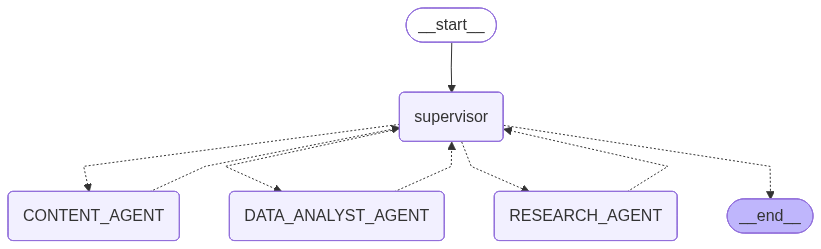

✅ Graph visualization generated


In [18]:
# Try to visualize the graph (requires graphviz)
try:
    from IPython.display import Image, display
    
    # Generate the graph visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✅ Graph visualization generated")
except Exception as e:
    print(f"ℹ️ Graph visualization not available: {e}")
    print("   Install pygraphviz or grandalf for visualization support")
    print("\n   Graph structure:")
    print("   START → supervisor → [CONTENT_AGENT | DATA_ANALYST_AGENT | RESEARCH_AGENT] → supervisor → END")


## Step 13: Test the Workflow

Now let's test the workflow with some sample queries! Each query type should be routed to a different agent:

| Query Type | Expected Agent |
|------------|----------------|
| Customer feedback, sentiment, complaints | CONTENT_AGENT |
| Metrics, behavior, churn, analytics | DATA_ANALYST_AGENT |
| Market research, competition, strategy | RESEARCH_AGENT |


In [19]:
from trulens.apps.langgraph import TruGraph
from trulens.connectors.snowflake import SnowflakeConnector
from trulens.providers.cortex import Cortex
from trulens.core.feedback.custom_metric import MetricConfig
from trulens.core.feedback.selector import Selector
from trulens.core.run import Run, RunConfig
from functools import partial
import uuid

print("✅ TruLens dependencies imported successfully!")


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ TruLens dependencies imported successfully!


In [20]:
# Connect TruLens to Snowflake for observability
# This uses the same session we created earlier

sf_connector = SnowflakeConnector(snowpark_session=session)
print("✅ Snowflake connector created for TruLens")

# Initialize the Cortex provider for client-side evaluations
# This provider will use Snowflake Cortex LLMs to compute custom metrics
trace_eval_provider = Cortex(
    model_engine="claude-opus-4-5",
    snowpark_session=session
)
print("✅ Cortex evaluation provider initialized")
print(f"   Model: {trace_eval_provider.model_engine}")


Running the TruLens dashboard requires providing a `password` to the `SnowflakeConnector`.


✅ Snowflake connector created for TruLens
✅ Cortex evaluation provider initialized
   Model: claude-opus-4-5


In [21]:
# Plan Quality - Evaluates how well the supervisor creates execution plans
f_plan_quality = MetricConfig(
    metric_implementation=partial(
        trace_eval_provider.plan_quality_with_cot_reasons,
        # enable_trace_compression=False
    ),
    metric_name="Plan Quality",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Plan Quality metric configured")

# Plan Adherence - Checks if the agent follows the execution plan
f_plan_adherence = MetricConfig(
    metric_implementation=partial(
        trace_eval_provider.plan_adherence_with_cot_reasons,
        # enable_trace_compression=False
    ),
    metric_name="Plan Adherence",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Plan Adherence metric configured")

# Execution Efficiency - Measures workflow efficiency
f_execution_efficiency = MetricConfig(
    metric_implementation=partial(
        trace_eval_provider.execution_efficiency_with_cot_reasons,
        # enable_trace_compression=False
    ),
    metric_name="Execution Efficiency",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Execution Efficiency metric configured")

# Logical Consistency - Verifies consistency across agent responses
f_logical_consistency = MetricConfig(
    metric_implementation=partial(
        trace_eval_provider.logical_consistency_with_cot_reasons,
        # enable_trace_compression=False
    ),
    metric_name="Logical Consistency",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Logical Consistency metric configured")


✅ Plan Quality metric configured
✅ Plan Adherence metric configured
✅ Execution Efficiency metric configured
✅ Logical Consistency metric configured


## Step 14: Instrument with TruLens and Run Evaluation

Now we wrap the LangGraph application directly with `TruGraph` and run evaluation with full LangGraph input states.

The evaluation dataset contains actual LangGraph state dicts (with `messages` key) that are passed directly to `graph.invoke()`.


In [22]:
# Generate unique app name and version
APP_NAME = f"Customer Intelligence Multi-Agent"
APP_VERSION = f"V{uuid.uuid4().hex[:8]}"

# Directly wrap the LangGraph graph with TruGraph
tru_app = TruGraph(
    app,  # The compiled StateGraph from Step 11
    app_name=APP_NAME,
    app_version=APP_VERSION,
    main_method=app.invoke,  # Use graph's invoke method directly
    connector=sf_connector,
)

print(f"✅ TruGraph instrumented app created")
print(f"   App Name: {APP_NAME}")
print(f"   App Version: {APP_VERSION}")


✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting stream_mode
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting invoke
	instrume

Evaluator thread encountered an error: 'str' object has no attribute 'get'


In [23]:
# Define all metrics to compute (server-side + client-side)
metrics_to_compute = [
    # Server-side metrics
    "answer_relevance",
    # Client-side metrics
    f_plan_quality,
    f_plan_adherence,
    f_execution_efficiency,
    f_logical_consistency,
]

---

## Summary

Congratulations! 🎉 You've successfully built an **efficiency-optimized multi-agent supervisor workflow** using LangGraph and Snowflake Cortex. Here's what we accomplished:

### Key Components Built:

1. **Extended State Management**: Custom state with `messages`, `plan`, `agent_outputs`, and `execution_errors`
2. **Supervisor Model**: `ChatSnowflake` for intelligent planning and synthesis (2 modes only)
3. **Specialized Agents**: Three `SnowflakeCortexAgent` instances with direct chaining
4. **Efficient Prompt Engineering**: Planning prompt emphasizing consolidated queries and clear tool separation
5. **Optimized Node Functions**: Agents route directly to each other without supervisor re-entry
6. **Graph Structure**: Linear execution with plan-based agent chaining

### Efficiency-Optimized Architecture:

```
User Query → Supervisor (Plan ONCE) → Agent1 → Agent2... → Supervisor (Synthesize ONCE) → Executive Summary
```

### Efficiency Improvements Implemented:

| Issue | Solution |
|-------|----------|
| **Repeated planning/re-planning** | Immutable plan - created once, locked with `planning_complete` flag |
| **Cascading error chains** | Aggregated error handling - errors collected and deduplicated, not appended per-chunk |
| **Supervisor bottleneck** | Direct agent chaining via `next_agent` field in plan steps |
| **Redundant tool invocations** | Planning prompt emphasizes consolidated SQL queries (one aggregation vs multiple) |
| **Duplicated invocations** | Supervisor only called twice (plan + synthesize), not between each agent |
| **Overlapping tooling** | Clear tool separation - each agent has ONE tool with distinct data sources |

### Planning Features:

The supervisor creates a **single, immutable execution plan** that includes:
- **`next_agent` Field**: Enables direct agent-to-agent routing
- **`consolidated_query`**: Encourages single queries instead of multiple separate calls
- **Clear Tool Boundaries**: CONTENT_AGENT (cortex_search), DATA_ANALYST_AGENT (cortex_analyst on metrics), RESEARCH_AGENT (cortex_analyst on analytics)
- **`total_steps`**: Explicit step count for progress tracking

### Error Handling Strategy:

- Errors collected in `state.execution_errors` array (not cascaded in output)
- Unique errors deduplicated before storage
- Graceful degradation - agents continue to next step even on partial errors
- Summary synthesis includes error count without verbose per-chunk messages

### Next Steps:

- **Add more agents**: Extend the workflow with additional specialized agents
- **Implement memory**: Add conversation persistence with LangGraph checkpointers
- **Add human-in-the-loop**: Include plan approval steps for critical decisions
- **Deploy to production**: Use LangGraph Cloud or LangGraph Studio for deployment

### Resources:

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Snowflake Cortex Documentation](https://docs.snowflake.com/en/user-guide/snowflake-cortex)
- [LangChain Snowflake Integration](https://python.langchain.com/docs/integrations/providers/snowflake)


In [24]:
import pandas as pd

# Define evaluation inputs as full LangGraph state dicts
# This passes the actual state that LangGraph expects directly to graph.invoke()
evaluation_inputs = [
    {
        "messages": [HumanMessage(content="Assess the churn risk for customers complaining about API issues.")],
    },
    {
        "messages": [HumanMessage(content="What industries have the highest customer lifetime value and represent our best strategic expansion opportunities?")],
    },
]

# Create DataFrame with the state dicts
queries_df = pd.DataFrame({"input_state": evaluation_inputs})

In [25]:
# Create unique run name
run_name = f"customer_intel_eval_{uuid.uuid4().hex[:8]}"

# Configure the evaluation run
# The dataset_spec maps to the column containing full LangGraph state dicts
run_config = RunConfig(
    run_name=run_name,
    dataset_name="customer_intelligence_queries",
    source_type="DATAFRAME",
    dataset_spec={"RECORD_ROOT.INPUT": "input_state"},  # Maps to state dict column
)

print(f"✅ Run configuration created")
print(f"   Run Name: {run_name}")
print(f"   Dataset: customer_intelligence_queries")
print(f"   Source: DataFrame with {len(queries_df)} input states")

# Add the run to the instrumented app
run: Run = tru_app.add_run(run_config=run_config)
print(f"\n✅ Run added to TruGraph app")

✅ Run configuration created
   Run Name: customer_intel_eval_bc1406c5
   Dataset: customer_intelligence_queries
   Source: DataFrame with 2 input states

✅ Run added to TruGraph app


In [26]:
print("\n🚀 Starting evaluation run...")
print(f"   Processing {len(queries_df)} queries through the multi-agent workflow\n")

run.start(input_df=queries_df)

print("✅ Run started!")



🚀 Starting evaluation run...
   Processing 2 queries through the multi-agent workflow


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📋 EXECUTION PLAN (IMMUTABLE)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

CONTENT_AGENT will search for API-related complaints, then DATA_ANALYST_AGENT will analyze churn patterns for those customers

📍 Steps (2 total):
   1. CONTENT_AGENT → DATA_ANALYST_AGENT
      Purpose: Find API-related complaints and extract customer I...
   2. DATA_ANALYST_AGENT → None
      Purpose: Get comprehensive churn risk metrics for identifie...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 CONTENT_AGENT analyzing...
   ✓ Complete (11798 chars)
   → Routing to DATA_ANALYST_AGENT
📊 DATA_ANALYST_AGENT analyzing...
   ⚠️ 18 unique error(s) during streaming
   ✓ Complete (27711 chars)
📊 Synthesizing results from 2 agent(s)...
   ⚠️ 3 error(s) occurred during execution
✅ Analysis complete


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
import time

# ============================================
# Wait for invocations to complete
# ============================================
print("⏳ Waiting for invocations to complete...")
print(f"   Initial Status: {run.get_status()}")

wait_count = 0
max_wait = 60  # Max 5 minutes (60 * 5 seconds)

while run.get_status() != "INVOCATION_COMPLETED" and wait_count < max_wait:
    time.sleep(5)
    wait_count += 1
    status = run.get_status()
    if wait_count % 6 == 0:  # Print status every 30 seconds
        print(f"   [{wait_count * 5}s] Status: {status}")

final_status = run.get_status()
print(f"\n✅ Final Status: {final_status}")

if final_status == "INVOCATION_COMPLETED":
    print("   All invocations completed successfully!")
else:
    print(f"   ⚠️ Run did not complete. Current status: {final_status}")


⏳ Waiting for invocations to complete...
   Initial Status: RunStatus.CREATED

✅ Final Status: RunStatus.INVOCATION_COMPLETED
   All invocations completed successfully!


In [28]:
# ============================================
# Compute evaluation metrics
# ============================================
run.compute_metrics(metrics_to_compute)

print("✅ Metrics computation initiated!")
print(f"   Current Status: {run.get_status()}")


Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid or not supported yet for cost estimation.
Error occurred while computing credits consumed for model claude-opus-4-5: Model claude-opus-4-5 not valid

✅ Metrics computation initiated!
   Current Status: RunStatus.INVOCATION_COMPLETED
